In [1]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlflow.models import infer_signature
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,age,education,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,...,company_type_MNC,company_type_Mid-size,company_type_Small,company_type_Startup,emi_scenario_Education EMI,emi_scenario_Home Appliances EMI,emi_scenario_Personal Loan EMI,emi_scenario_Vehicle EMI,house_type_Own,house_type_Rented
0,38.0,0,11.321777,0.641854,9.903538,0.055408,0.055408,0.000000,0.00000,8.881975,...,0,1,0,0,0,0,1,0,0,1
1,38.0,1,9.975855,2.079442,0.000000,-0.874653,-0.874653,8.537192,0.00000,7.244942,...,1,0,0,0,0,0,0,0,0,0
2,38.0,0,11.363276,1.916923,0.000000,0.985470,0.985470,0.000000,0.00000,9.230241,...,0,0,0,1,1,0,0,0,1,0
3,58.0,2,11.109473,1.163151,0.000000,1.915531,1.915531,9.341456,0.00000,8.732466,...,0,1,0,0,0,0,0,1,1,0
4,48.0,0,10.956073,1.481605,0.000000,0.985470,0.985470,9.148571,9.69591,8.188967,...,0,1,0,0,0,1,0,0,0,0


In [3]:
X = df.drop(["max_monthly_emi","emi_eligibility"],axis = 1)
y = df['max_monthly_emi']


rfr_model = RandomForestRegressor(n_estimators=200, random_state=42)
rfr_model.fit(X,y)


features_importance_df = pd.DataFrame({
    'Features':X.columns,
    'Importance':rfr_model.feature_importances_

})

features_importance_df = features_importance_df.sort_values(by = 'Importance',ascending=False)


features_importance_df

,Features,Importance
20,expense_to_income,0.621353
19,debt_to_income,0.169887
2,monthly_salary,0.078207
13,current_emi_amount,0.026650
12,existing_loans,0.025038
23,savings_buffer_ratio,0.013572
8,college_fees,0.010864
14,credit_score,0.010720
10,groceries_utilities,0.010219
37,house_type_Rented,0.006410


In [4]:
import seaborn as sns

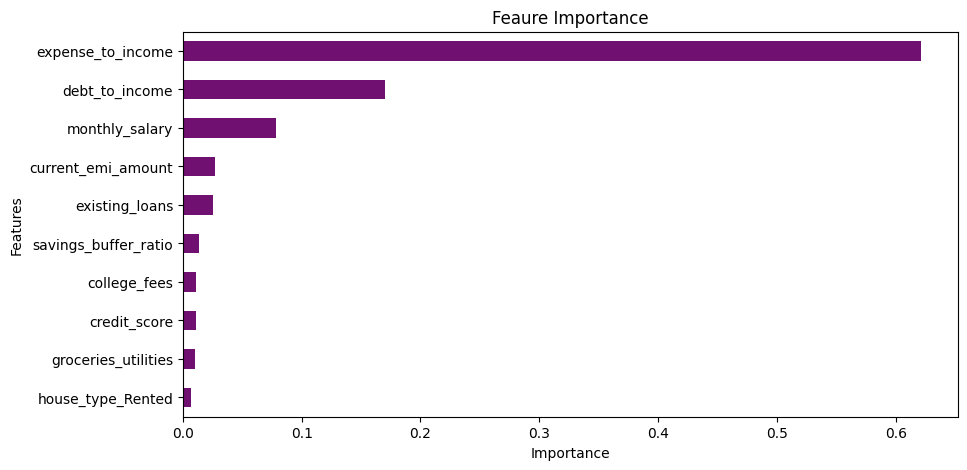

In [5]:
plt.figure(figsize = (10,5))
sns.barplot(x = features_importance_df['Importance'][:10], y = features_importance_df['Features'][:10], color='purple',width = 0.5)
plt.title("Feaure Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [6]:
features_importance_df['Cumulative'] =  features_importance_df['Importance'].cumsum()
top_features = features_importance_df[features_importance_df['Cumulative']<=0.9]['Features'].tolist()
print(top_features)

['expense_to_income', 'debt_to_income', 'monthly_salary', 'current_emi_amount']


In [7]:
r_df = df[top_features]
r_df["target"] = df["max_monthly_emi"]

C:\Users\sachi\AppData\Local\Temp\ipykernel_21004\2361917980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df["target"] = df["max_monthly_emi"]


In [8]:
r_df.to_csv("regression_data.csv",index = False)

Model Training

In [9]:
df = pd.read_csv("regression_data.csv")
df.head()

,expense_to_income,debt_to_income,monthly_salary,current_emi_amount,target
0,0.725182,0.242131,11.321777,9.903538,6.216606
1,0.716279,0.190698,9.975855,8.318986,6.552508
2,0.413473,0.000000,11.363276,0.000000,10.074537
3,0.559880,0.000000,11.109473,0.000000,9.690975
4,0.934555,0.000000,10.956073,0.000000,6.216606


In [10]:
X = df.drop('target', axis = 1)
y = df['target']

In [11]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}

results = {}

for name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    results[name] = {
        "MAE" : mae,
        "MSE" : mse,
        "RMSE" : rmse,
        "R2" : r2
    }


results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R2
Linear Regression,0.796369,1.022603,1.011238,0.434299
Decision Tree Regressor,0.256190,0.232155,0.481825,0.871573
Random Forest Regressor,0.211252,0.147869,0.384537,0.918200
XGBoost Regressor,0.198896,0.128244,0.358112,0.929056


Cross validation

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

rfe = RandomForestRegressor(n_estimators = 100, random_state = 42)

kf = KFold(n_splits = 5, shuffle = True, random_state=42)

cv_scores = cross_val_score(rfe, X, y, cv = kf, scoring='r2')

print(f'All 5-Fold Scores: {cv_scores}')
print()

print(f'Mean R2 Score: {np.mean(cv_scores):.4f}')

All 5-Fold Scores: [0.99998764 0.99998893 0.99998661 0.99998903 0.99999003]

Mean R2 Score: 1.0000


Parameter Tunning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}


rf = RandomForestRegressor(random_state=42, n_jobs=1)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,            
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1             
)

# Fit the search
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R2 Score:", random_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.2min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, 

In [11]:
best_params = random_search.best_params_

In [13]:
best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [13]:
# Set MLflow tracking
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("EMI_Regression")

2025/10/07 10:15:27 INFO mlflow.tracking.fluent: Experiment with name 'EMI_Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///d:/backup/AI course '
 'work/Guvi/Assignment2_EMI_Predict/mlruns/407208619469201270'), creation_time=1759812327389, experiment_id='407208619469201270', last_update_time=1759812327389, lifecycle_stage='active', name='EMI_Regression', tags={}>

In [14]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train a model and log it to MLflow
    """
    with mlflow.start_run(run_name=model_name):
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        if hasattr(model, 'get_params'):
            params = model.get_params()
            for param, value in params.items():
                mlflow.log_param(param, value)
        
        # Log metrics
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"{model_name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
        
        return r2, mlflow.active_run().info.run_id

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, random_state=42)
}

best_r2 = 0
best_model_name = ""
best_run_id = ""

# Train and compare all models
for name, model in models.items():
    r2, run_id = train_and_log_model(model, name, X_train, y_train, X_test, y_test)
    if r2 > best_r2:
        best_r2 = r2
        best_model_name = name
        best_run_id = run_id

print(f"\nBest Model: {best_model_name} with accuracy: {best_r2:.4f}")

2025/10/07 10:15:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 10:15:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Linear Regression - RMSE: 1.0112, R2: 0.4343


2025/10/07 10:15:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 10:16:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree Regressor - RMSE: 0.4819, R2: 0.8715


2025/10/07 10:19:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 10:19:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Regressor - RMSE: 0.3843, R2: 0.9183


2025/10/07 10:19:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 10:19:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost Regressor - RMSE: 0.3581, R2: 0.9291

Best Model: XGBoost Regressor with accuracy: 0.9291


In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np

def cross_validation_with_mlflow_regression(model, model_name, X, y, cv=5):
    """
    Perform cross-validation for regression and log results to MLflow
    """
    with mlflow.start_run(run_name=f"{model_name}_CrossValidation"):
        
        # Perform cross-validation predictions
        y_pred = cross_val_predict(model, X, y, cv=cv)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        # Log parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("cv_folds", cv)
        
        # Log metrics
        mlflow.log_metric("cv_rmse", rmse)
        mlflow.log_metric("cv_mae", mae)
        mlflow.log_metrics("cv_mse", mse)
        mlflow.log_metric("cv_r2", r2)
        
        # Train on full data and log model
        model.fit(X, y)
        mlflow.sklearn.log_model(model, "model")
        
        print(f"{model_name} CV Results:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R2 Score: {r2:.4f}")
        
        return {"rmse": rmse, "mae": mae, "r2": r2}, mlflow.active_run().info.run_id


In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np

def hyperparameter_tuning_with_mlflow(model, param_grid, X_train, y_train, X_test, y_test, 
                                                 search_type='grid', cv=5, n_iter=10):
    """
    Perform hyperparameter tuning for regression and log to MLflow
    search_type: 'grid' for GridSearchCV or 'random' for RandomizedSearchCV
    """
    
    parent_run_name = f"HyperparameterTuning_{model.__class__.__name__}"
    
    with mlflow.start_run(run_name=parent_run_name) as parent_run:
        
        # Choose search method
        if search_type == 'grid':
            search = GridSearchCV(model, param_grid, cv=cv, 
                                  scoring='neg_root_mean_squared_error', 
                                  n_jobs=-1, verbose=1)
        else:
            search = RandomizedSearchCV(model, param_grid, cv=cv, 
                                        scoring='neg_root_mean_squared_error',
                                        n_iter=n_iter, n_jobs=-1, verbose=1, random_state=42)
        
        # Fit search
        search.fit(X_train, y_train)
        
        # Log parent run info
        mlflow.log_param("search_type", search_type)
        mlflow.log_param("cv_folds", cv)
        mlflow.log_param("param_grid", str(param_grid))
        
        # Log best parameters and CV score (neg RMSE → convert to positive)
        best_rmse = -search.best_score_
        mlflow.log_params(search.best_params_)
        mlflow.log_metric("best_cv_rmse", best_rmse)
        
        # Evaluate on test set
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse) 
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        mlflow.log_metric("test_mse", test_mse)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_r2", test_r2)
        
        # Log best model
        mlflow.sklearn.log_model(best_model, "best_model")
        
        # Log all CV results as nested runs
        cv_results = pd.DataFrame(search.cv_results_)
        for idx, row in cv_results.iterrows():
            with mlflow.start_run(run_name=f"config_{idx}", nested=True):
                # Log parameters for this configuration
                params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
                mlflow.log_params(params)
                
                # Log metrics (convert neg RMSE to positive)
                mean_rmse = -row['mean_test_score']
                std_rmse = row['std_test_score']
                mlflow.log_metric("mean_test_rmse", mean_rmse)
                mlflow.log_metric("std_test_rmse", std_rmse)
                mlflow.log_metric("rank", row['rank_test_score'])
        
        print(f"\nBest Parameters: {search.best_params_}")
        print(f"Best CV RMSE: {best_rmse:.4f}")
        print(f"Test RMSE: {test_mse:.4f}")
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
        print(f"Test R2 Score: {test_r2:.4f}")
        
        return best_model, search.best_params_, parent_run.info.run_id


In [20]:
# XGBoost Regressor - Hyperparameter tuning
from xgboost import XGBRegressor

param_grid_xgb_reg = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]  # L2 regularization
}

best_xgb_reg, best_params_reg, tuning_run_id_reg = hyperparameter_tuning_with_mlflow(
    XGBRegressor(random_state=42, eval_metric='rmse'),
    param_grid_xgb_reg,
    X_train, y_train, X_test, y_test,
    search_type='random',  # or 'grid'
    cv=5,
    n_iter=20
)

print("Best Parameters:", best_params_reg)
print("MLflow Run ID:", tuning_run_id_reg)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025/10/07 10:38:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 10:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV RMSE: 0.3598
Test RMSE: 0.1266
Test RMSE: 0.3559
Test MAE: 0.1971
Test R2 Score: 0.9299
Best Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
MLflow Run ID: c88b2b568a3b49f2855fb32044c4e89a


In [21]:
import mlflow

def register_best_model(run_id, model_name="MyBestModel"):
    
    model_uri = f"runs:/{run_id}/model"
    
    # Register model in MLflow Model Registry
    model_details = mlflow.register_model(model_uri, model_name)
    
    print(f"Model registered successfully: {model_name}")
    print(f"Version: {model_details.version}")
    
    return model_details


In [22]:
import mlflow

def load_model_from_mlflow(run_id=None, model_name=None, version=None):
    """
    Load a model from MLflow.
    
    Options:
        1. By run_id (from a specific MLflow run)
        2. By model_name and version (from MLflow Model Registry)
    
    Args:
        run_id (str, optional): MLflow run ID to load the model from.
        model_name (str, optional): Name of the model in MLflow Model Registry.
        version (str or int, optional): Version of the model in registry.
    
    Returns:
        model: Loaded scikit-learn model.
    """
    
    if run_id:
        # Load model directly from a run
        model_uri = f"runs:/{run_id}/model"
        model = mlflow.sklearn.load_model(model_uri)
        print(f"Model loaded from run: {run_id}")
    
    elif model_name and version:
        # Load model from MLflow Model Registry
        model_uri = f"models:/{model_name}/{version}"
        model = mlflow.sklearn.load_model(model_uri)
        print(f"Model loaded from registry: {model_name} version {version}")
    
    else:
        raise ValueError("Provide either run_id or (model_name and version)")
    
    return model


In [24]:


loaded_model = load_model_from_mlflow(model_name="MaxEMIRegressor", version=2)


predictions = loaded_model.predict(X_test)
predictions

Model loaded from registry: MaxEMIRegressor version 2


array([8.444088 , 8.492916 , 6.2430124, ..., 7.23067  , 9.345547 ,
       6.274013 ], shape=(80960,), dtype=float32)